In [30]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as ras 
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay

## Loading the data

We are using pd.read_csv function to loading the data from CSV to DataFrame and nrows parameter is for loading the 10000 row from the csv file

In [8]:
df = pd.read_csv("onlinefraud.csv", nrows=10000) 
print(df.head())
# print(df.info)


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## Checking the null values

In [9]:
df.isnull().sum() 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Here is no any null Values so no need to handle this

In [10]:
# #Data Preprocessing
# type_new = pd.get_dummies(df['type'], drop_first=True)
# df_new = pd.concat([df, type_new], axis=1)
# #df_new.head()

## Sampling the data

Sampling the data to check how many number of columns are int, float, object present in the dataset 

In [11]:
# Sampling the data find the number of int, float, object columns
object = (df.dtypes == 'object')
object_columns = list(object[object].index)
print("Categorial Values" , len(object_columns))

integer = (df.dtypes == 'int')
integer_columns = list(integer[integer].index)
print("Ineger columns ", len(integer_columns))

float = (df.dtypes == 'float')
float_columns = list(float[float].index)
print("Float columns ", len(float_columns))

Categorial Values 3
Ineger columns  3
Float columns  5


## Ploting the graph

Ploting the graph to check the hightest faurd are in which payment type and checking the relation between type and amount column

<Axes: xlabel='type', ylabel='amount'>

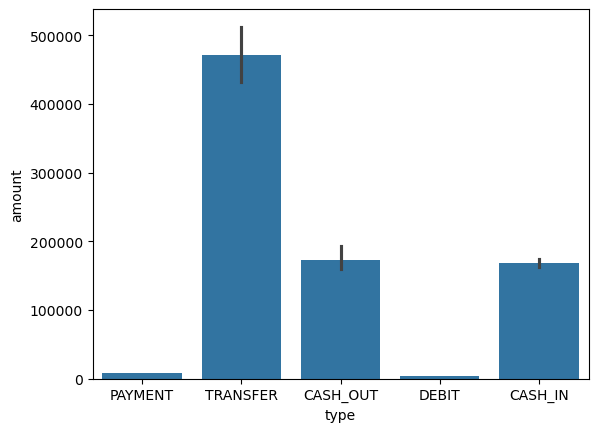

In [12]:
sns.barplot(x='type', y='amount', data=df)

## Scale the Values

Here We are Scaling the Vlaues of some int. Column using normalize it will arrange the all values between 0 to 1 according to their values

In [13]:
# Scale the column
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Implement the  normalization 
minmax_scaler = MinMaxScaler()

df[columns_to_scale] = minmax_scaler.fit_transform(df[columns_to_scale])

print("Normalized Data :", df[columns_to_scale].head())



Normalized Data :      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0  0.000984       0.013158        0.012321        0.000000             0.0
1  0.000186       0.001643        0.001490        0.000000             0.0
2  0.000018       0.000014        0.000000        0.000000             0.0
3  0.000018       0.000014        0.000000        0.001085             0.0
4  0.001167       0.003214        0.002297        0.000000             0.0


<Axes: xlabel='type', ylabel='amount'>

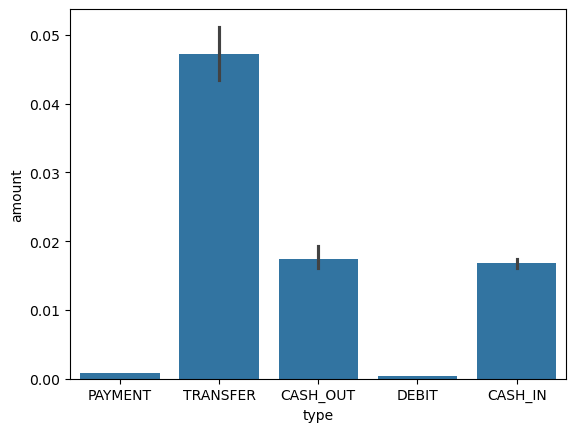

In [14]:
sns.barplot(x='type', y='amount', data=df)

Counting the Values of isFraud 

In [15]:
df['isFraud'].value_counts()

isFraud
0    9932
1      68
Name: count, dtype: int64

Ploting the EDA to the distribution of values in the step column in the dataset

<Axes: xlabel='step', ylabel='Count'>

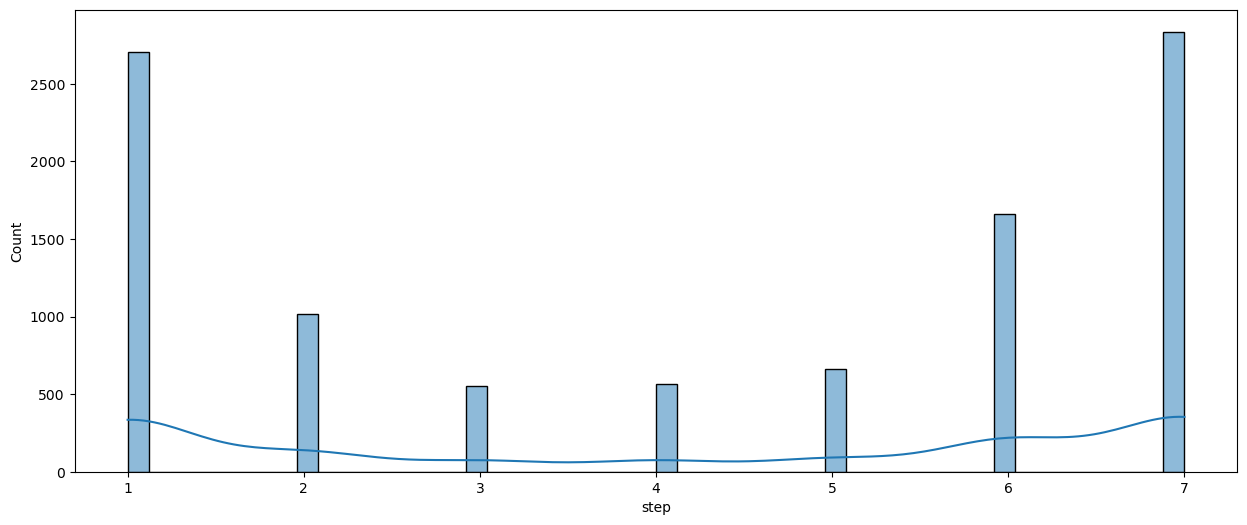

In [16]:
#EDA
plt.figure(figsize=(15, 6))
sns.histplot(df['step'], bins=50, kde=True)  


## Corelation
Checking the coorelation between all columns

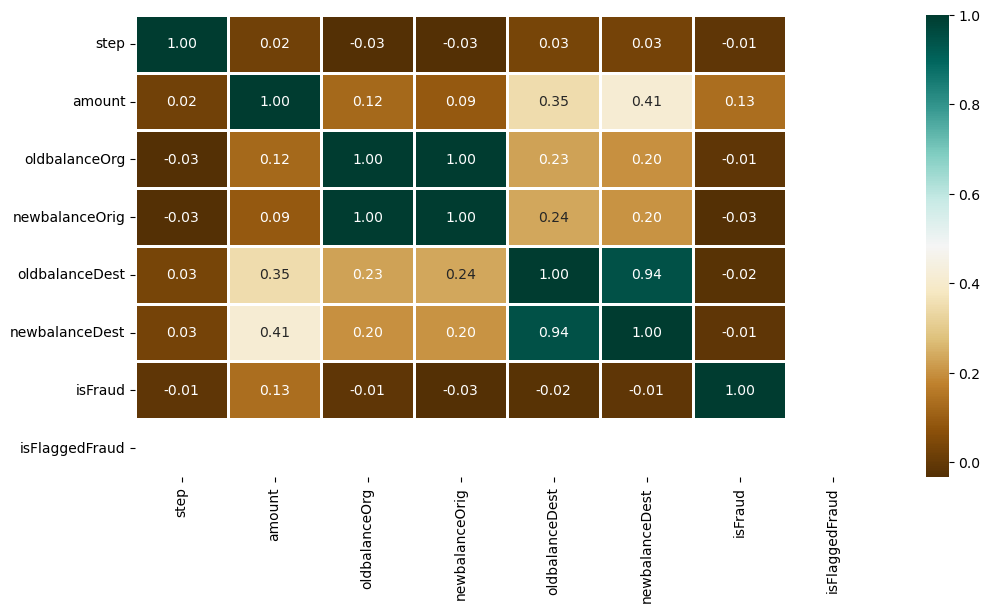

In [17]:
numeric_df = df.select_dtypes(include=[np.number])

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(),
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True)
plt.show()


text column type into numerical columns so that a machine learning model can work with it

In [18]:
# Data Preprocessing
type_new = pd.get_dummies(df['type'], drop_first=True)
df_new = pd.concat([df, type_new], axis=1)
df_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,0.000984,C1231006815,0.013158,0.012321,M1979787155,0.000000,0.0,0,0,False,False,True,False
1,1,PAYMENT,0.000186,C1666544295,0.001643,0.001490,M2044282225,0.000000,0.0,0,0,False,False,True,False
2,1,TRANSFER,0.000018,C1305486145,0.000014,0.000000,C553264065,0.000000,0.0,1,0,False,False,False,True
3,1,CASH_OUT,0.000018,C840083671,0.000014,0.000000,C38997010,0.001085,0.0,1,0,True,False,False,False
4,1,PAYMENT,0.001167,C2048537720,0.003214,0.002297,M1230701703,0.000000,0.0,0,0,False,False,True,False


Selecting the Feature and Target from the new_df

In [19]:
X = df_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = df_new['isFraud']

In [20]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0.000984,0.013158,0.012321,0.000000,0.0,0,False,False,True,False
1,1,0.000186,0.001643,0.001490,0.000000,0.0,0,False,False,True,False
2,1,0.000018,0.000014,0.000000,0.000000,0.0,0,False,False,False,True
3,1,0.000018,0.000014,0.000000,0.001085,0.0,0,True,False,False,False
4,1,0.001167,0.003214,0.002297,0.000000,0.0,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,7,0.000046,0.000068,0.000032,0.000000,0.0,0,False,False,True,False
9996,7,0.000824,0.000891,0.000252,0.000000,0.0,0,False,False,True,False
9997,7,0.000606,0.002429,0.001948,0.000000,0.0,0,False,False,True,False
9998,7,0.031780,0.000843,0.000000,0.005286,0.0,0,False,False,False,True


In [21]:
y

0       0
1       0
2       1
3       1
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: isFraud, Length: 10000, dtype: int64

In [22]:
X.shape, y.shape

((10000, 11), (10000,))

Spliting the data 

Divide the data into training and testing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

## Models

Implement the Logistic model and check the accuracy

In [24]:
print("Logistic")
Logistic_model =  LogisticRegression()
Logistic_model.fit(X_train, y_train)
train_pred = Logistic_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Logistic_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

Logistic
Training Accuracy 0.9410847701149425
Testing Accuracy 0.9411170928667565


Implement the XGB model and check the accuracy

In [25]:
print("XBG")
Xgb_model =  XGBClassifier()
Xgb_model.fit(X_train, y_train)
train_pred = Xgb_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Xgb_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

XBG
Training Accuracy 1.0
Testing Accuracy 0.9974644299173236


Implement the SVC model and check the accuracy

In [26]:
print("SVC")
Svc_model =  SVC(kernel= 'rbf', probability= True)
Svc_model.fit(X_train, y_train)
train_pred = Svc_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Svc_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

SVC
Training Accuracy 0.9527083333333333
Testing Accuracy 0.9538550278792539


Implement the Random Classifier model and check the accuracy

In [27]:
print("Random Forest")
Random_model = RandomForestClassifier(n_estimators= 10, criterion= 'entropy', random_state=14) 
Random_model.fit(X_train, y_train)
train_pred = Random_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Random_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

Random Forest
Training Accuracy 1.0
Testing Accuracy 0.9450646510286482


#### Here we can see XGB Booost is giving the best accuracy

## Confusion Matrix
It 's a tool to check the performance of our model

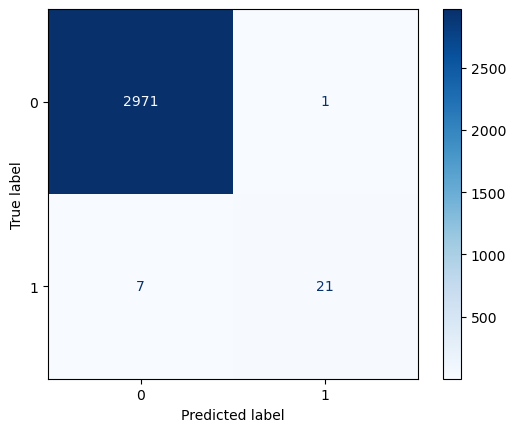

In [ ]:
y_pred = Xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[2971    1]
 [   7   21]]
